# Conditioning to classes

En concreto deberás de crear una *red generativa condicionada* de la que puedas obtener imágenes para cada una de las clases del dataset. Una vez lo hayas entrenado, visualiza la generación de 3 imágenes de la clase RANA (🐸) y 3 imágenes de la clase CABALLO (🐎). **Dada la complejidad del dataset y la poca resolución de las imágenes es normal esperar imágenes donde se identifique claramente el objeto generado.**

<br>
<img src='https://miro.medium.com/max/424/1*0hHJfc0V_Km_AgKkP892fw.png'>
<br>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.datasets.cifar10 import load_data
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *

# Cargamos el dataset CIFAR10 en un variable.
(X_train, Y_train), (X_test, Y_test) = load_data()

# Normalizamos el input.
X_train = X_train / 255
X_test  = X_test  / 255

# Codificamos One-Hot el output.
Y_train = to_categorical(Y_train)
Y_test  = to_categorical(Y_test)


170508288/170498071 [==============================] - 11s 0us/step


In [ ]:
# Nombre de las clases ordenadas por el índice correspondiente.
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

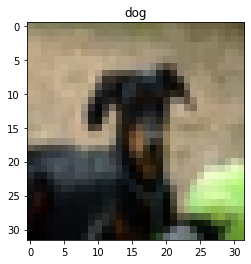

In [ ]:
# Seleccionamos un índice aleatorio.
idx = np.random.randint(0, 5000)
# Visualizamos una de las imágenes.
plt.imshow(X_train[idx])
plt.title(class_names[np.argmax(Y_train[idx])])
plt.show()

In [ ]:
# CONSTRUCCIÓN DEL MODELO
#Modelo del discriminador
latent_dim  = 128
image_size  = 32
num_classes = 10

def get_discriminator():
  #Creamos el discriminador
  discriminator = Sequential(name = "discriminator")

  discriminator.add(Input(shape=(image_size, image_size, 3 + num_classes)))

  discriminator.add(Conv2D(64, kernel_size=4, strides=2, padding="same"))
  discriminator.add(BatchNormalization())
  discriminator.add(LeakyReLU(alpha=0.2))
  
  discriminator.add(Conv2D(128, kernel_size=4))
  discriminator.add(BatchNormalization())
  discriminator.add(LeakyReLU(alpha=0.2))
  
  discriminator.add(Conv2D(128, kernel_size=4))
  discriminator.add(BatchNormalization())
  discriminator.add(LeakyReLU(alpha=0.2))
  
  discriminator.add(GlobalMaxPooling2D())
  discriminator.add(Dense(1, activation="sigmoid"))

  discriminator.summary()
  return discriminator

get_discriminator()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_94 (Conv2D)          (None, 16, 16, 64)        13376     
                                                                 
 batch_normalization_94 (Bat  (None, 16, 16, 64)       256       
 chNormalization)                                                
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 64)        0         
                                                                 
 conv2d_95 (Conv2D)          (None, 13, 13, 128)       131200    
                                                                 
 batch_normalization_95 (Bat  (None, 13, 13, 128)      512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 13, 13, 128)     

In [ ]:
#Modelo del generador


def get_generator(latent_dim=128):

  generator = Sequential(name="generator")
  
  # 💡 >>> Ahora el input recibe el vector latente y el
  #        vector One-hot concatenado.
  generator.add(Input(shape=(latent_dim + num_classes)))
  
  generator.add(Dense(2 * 2 * latent_dim))
  generator.add(Reshape((2, 2, latent_dim)))

  generator.add(Conv2DTranspose(128, kernel_size=4, strides=4))
  generator.add(BatchNormalization())
  generator.add(LeakyReLU(alpha=0.2))

  generator.add(Conv2DTranspose(512, kernel_size=4, strides=4, padding="valid"))
  generator.add(BatchNormalization())
  generator.add(LeakyReLU(alpha=0.2))
  
  generator.add(Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"))

  generator.summary()
  return generator

get_generator()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 512)               71168     
                                                                 
 reshape (Reshape)           (None, 2, 2, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        262272    
 nspose)                                                         
                                                                 
 batch_normalization_97 (Bat  (None, 8, 8, 128)        512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 512)      10

In [ ]:
class GAN(tf.keras.Model):

  def __init__(self, discriminator, generator, latent_dim):
      super(GAN, self).__init__()
      # Guardamos el discriminador y el generador.
      self.discriminator = discriminator
      self.generator     = generator
      self.latent_dim    = latent_dim

  def compile(self, d_optimizer, g_optimizer, loss_fn):
    super(GAN, self).compile(d_optimizer, g_optimizer, loss_fn)
    self.d_optimizer = d_optimizer
    self.g_optimizer = g_optimizer
    self.loss_fn = loss_fn
  
  def train_step(self, data):

    # 💡 >>> Ahora los datos son el input y las etiquetas.
    real_images, one_hot_labels = data

    # 💡 >>> Formateamos el vector One-hot a tamaño de imagen.
    image_one_hot_labels = one_hot_labels[:, :, None, None]
    image_one_hot_labels = tf.repeat(image_one_hot_labels, repeats=[image_size * image_size])
    image_one_hot_labels = tf.reshape(image_one_hot_labels, (-1, image_size, image_size, num_classes))

    # ----------- ENTRENAMIENTO DEL DETECTOR ------------- #

    # Tamaño del lote.
    batch_size = tf.shape(real_images)[0]

    # Generamos vectores aleatorios como input de la red generadora.
    random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

     # 💡 >>> Añadimos la info de la clase a los vectores de entrada del generador.
    random_latent_vectors = tf.concat([random_latent_vectors, one_hot_labels], axis=1)

    # Usamos los vectores para generar imágenes aleatorias. (Decodificamos)
    fake_images = self.generator(random_latent_vectors)

    # 💡 >>> Añadimos la info de la clase a las imágenes de entrada del decodificador.
    fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], -1)
    real_image_and_labels = tf.concat([real_images, image_one_hot_labels], -1)

    # Las concatenamos al set de imágenes reales.
    combined_images = tf.concat([real_image_and_labels, fake_image_and_labels], axis=0)

    # Generamos el output para cada imagen (Real: 1 / Fake: 0)
    labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)

    # Add random noise to the labels - important trick!
    labels += 0.05 * tf.random.uniform(tf.shape(labels))

    with tf.GradientTape() as tape:

      # Predicciones hechas por el discrminador.
      predictions = self.discriminator(combined_images)

      # Evaluamos con la función de coste los resultados del discriminador.
      d_loss = self.loss_fn(labels, predictions)

    # Calculamos el gradiente con el error del discriminador.
    grads = tape.gradient(d_loss, self.discriminator.trainable_weights)

    # Actualizamos los parámetros con los gradientes.
    self.d_optimizer.apply_gradients(
          zip(grads, self.discriminator.trainable_weights)
    )

    # ----------- ENTRENAMIENTO DEL GENERADOR ------------- #

    # Creamos nuevos vectores para generar imágenes aleatorias. (Decodificamos)
    random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

    # Creamos las etiquetas con las que supervisar el entrenamiento del generador.
    misleading_labels = tf.ones((batch_size, 1))

    # Entrenamos al generador SIN actualizar al detector!
    with tf.GradientTape() as tape:

      # 💡 >>> Añadimos la info de la clase a los vectores de entrada del generador.
      random_latent_vectors = tf.concat([random_latent_vectors, one_hot_labels], axis=1)

      # 💡 >>> Generamos y añadimos la info de las clases.
      fake_images = self.generator(random_latent_vectors)
      fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], -1)

      # Obtenemos nuevas predicciones pasándole al discriminador lo generado.
      predictions = self.discriminator(fake_image_and_labels)

      # Calculamos el error del generador en su tarea de confundir al discriminador.
      g_loss = self.loss_fn(misleading_labels, predictions)

    # Calculamos el gradiente del generador.
    grads = tape.gradient(g_loss, self.generator.trainable_weights)

    # Actualizamos los parámetros con los gradientes.
    self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

    return {}

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# 💡 >>> Generamos el ImageDataGenerator.
train_gen = ImageDataGenerator().flow(X_train.reshape(-1, 32, 32, 3), Y_train)

In [ ]:
from tensorflow.keras.callbacks import Callback

# 💡 >>> Creamos un callback personalizado para visualizar la evolución
# del generador tras cada época.
class GANMonitor1(Callback):

    def on_epoch_end(self, epoch, logs=None):

        random_latent_vectors = tf.random.normal(shape=(3, self.model.latent_dim))
        # Generamos siempre vectores d la clase frog.
        one_hot_vectors1 = tf.reshape(tf.repeat(to_categorical(6, num_classes=10)[None,:], repeats=3, axis=0), (3, num_classes))
       
        generated_image = self.model.generator(tf.concat([random_latent_vectors, one_hot_vectors1], axis=1))

        fig, axs = plt.subplots(1, 3)

        for i in range(3):
          if generated_image.shape[3] > 1:
            fig.axes[i].imshow(generated_image[i,:,:,:])
            fig.axes[i].axis("off")
          else:
            fig.axes[i].matshow(generated_image[i,:,:,0])
            fig.axes[i].axis("off")

        plt.show()

class GANMonitor2(Callback):

    def on_epoch_end(self, epoch, logs=None):

        random_latent_vectors = tf.random.normal(shape=(3, self.model.latent_dim))
        # Generamos siempre vectores de la clase horse.
        one_hot_vectors1 = tf.reshape(tf.repeat(to_categorical(7, num_classes=10)[None,:], repeats=3, axis=0), (3, num_classes))
       
        generated_image = self.model.generator(tf.concat([random_latent_vectors, one_hot_vectors1], axis=1))

        fig, axs = plt.subplots(1, 3)

        for i in range(3):
          if generated_image.shape[3] > 1:
            fig.axes[i].imshow(generated_image[i,:,:,:])
            fig.axes[i].axis("off")
          else:
            fig.axes[i].matshow(generated_image[i,:,:,0])
            fig.axes[i].axis("off")

        plt.show()

In [ ]:
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *

# Creamos una GAN con nuestra clase.
gan = GAN(discriminator=get_discriminator(), generator=get_generator(), latent_dim=latent_dim)

# Configuramos los optimizadores de cada parte...
gan.compile(d_optimizer=Adam(learning_rate=0.0005),
            g_optimizer=Adam(learning_rate=0.0005),
            loss_fn=BinaryCrossentropy())



Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_98 (Conv2D)          (None, 16, 16, 64)        13376     
                                                                 
 batch_normalization_99 (Bat  (None, 16, 16, 64)       256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 conv2d_99 (Conv2D)          (None, 13, 13, 128)       131200    
                                                                 
 batch_normalization_100 (Ba  (None, 13, 13, 128)      512       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 13, 13, 128)     

In [ ]:
gan.fit(train_gen, epochs=1000, batch_size = 8, callbacks=[GANMonitor1(), GANMonitor2()], steps_per_epoch=100)